In [1]:
%reload_ext lab_black

In [2]:
import control
import math
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.interpolate import interp1d

# Selecting Key Technical Specifications

We will design a 20V to 5V/5A buck converter using the Diodes Incorporated [AP64500](https://www.diodes.com/assets/Datasheets/AP64500.pdf), an integrated synchronous buck converter. This power converter is intended to be used as a generic power source with reasonably good performance characteristics (steady-state voltage ripple, load step transient voltage overshoot and recovery time).

Selecting the target ripple and transient response specifications depends on what is required by the load. Steady-state voltage ripple is a fundamental source of conducted noise. A load step transient response that is too large (or too long) may result in overvoltage/undervoltage at the downstream loads.

As a point of comparison, the [Keysight E36300](https://www.keysight.com/us/en/assets/7018-05629/data-sheets/5992-2124.pdf) is a popular generic mid-size switched-mode power supply capable of 2mVpp ripple and a 15mV settling band given a 5A load step (50us time to recover).

We will aim for something a bit more modest with 5mVpp ripple and a 30mV settling band given a 2.5A load step (50us time to recover). The target loop gain crossover frequency is generally recommended to be 1/10 the switching frequency to avoid significant interaction with the current-mode control sample-and-hold effect.

In [3]:
vin_max = 20  # 20V input, max
vout = 5  # 5V output, fixed
iout_max = 5  # 5A output, max

fsw = 500e3  # 500kHz switching frequency, fixed
fc_target = fsw / 10  # 50kHz crossover frequency, target

iripple_target = 0.3 * 5  # 1.5A ripple current, target
vripple_target = 5e-3  # 5mV ripple voltage, target

istep = iout_max / 2  # 2.5A load step, typical
vstep_target = 30e-3  # 30mV load step voltage overshoot, target
tsettle_target = 50e-6  # 50us load step recovery time, target

# Designing for Steady-State Voltage Ripple
## Sizing the Inductor for Current Ripple

The buck converter datasheet recommends a ripple current between 30% to 50% of the maximum output current (5A). This is more of a guidance than a strict specification, but it is not recommended to stray far outside these bounds. The inductor current ripple may impact the internal design of the buck converter:
1. The boundary between continuous and discontinuous conduction mode, or in the case of the AP64500, the boundary between pulse width and pulse frequency modulation. Higher ripple current increases the load current at which the converter must transition to discontinuous conduction mode.
2. Power converter efficiency at various load levels. Higher inductance (and thus lower ripple current) reduces magnetic core losses but increases winding resistance losses at high load.
3. The peak current limit detection threshold and associated protection circuitry.
4. Larger ripple current requires more agressive slope compensation to eliminate sub-harmonic oscillation at duty cycles above 50%.

We will select a standard inductance of 5.6uH for a resulting ripple current of 1.34A (27% of 5A).

In [4]:
L_min = (vout / vin_max) * (vin_max - vout) / iripple_target / fsw
print("Minimum Inductance: {:0.1f} uH".format(L_min * 1e6))

Minimum Inductance: 5.0 uH


In [5]:
L = 5.6e-6  # 5.6uH (larger than minimum required)
iripple = (vout / vin_max) * (vin_max - vout) / (L * fsw)
print("Ripple Current: {:0.2f} A".format(iripple))

Ripple Current: 1.34 A


## Selecting Output Capacitance for Voltage Ripple

Low steady-state voltage ripple is achieved by selecting capacitors which minimize the output impedance at the switching frequency. These are usually smaller (high bandwidth) ceramic capacitors (low series resistance).

We will use ceramic capacitors from the [AVX X7R MLCC](https://datasheets.kyocera-avx.com/X7RDielectric.pdf) commercial series. Keep in mind that the effective capacitance changes as a function of voltage, temperature, and frequency. The final PCB layout will also impact the effective series inductance and resistance. We will select capacitor voltage ratings to be at least 4x the DC operating point (5V). Other component variations will be accounted for later when the overall loop gain is designed to have significant stability margin.

Plotted below a few capacitor impedances; the datasheet unfortunately does not provide much detail on each capacitor's series resistance and self-resonant frequency. Instead we can use the [KEMET KSIM](https://ksim3.kemet.com/capacitor-simulation) tool to view a chart of a similar capacitor's impedance over frequency.

In [6]:
def cercap(c, esr, srf):
    # Return the ceramic capacitor impedance in the s-domain.
    #    c: capacitance (F)
    #    esr: series resistance (Ohm)
    #    srf: self-resonant frequency (Hz)
    esl = (1 / (srf * math.tau)) ** 2 / c
    return control.tf(1, [c, 0]) + control.tf([esl, 0], 1) + esr

In [7]:
cap1n = cercap(c=1e-9, esr=260e-3, srf=260e6)  # 0805, 1nF, 200V
cap10n = cercap(c=10e-9, esr=60e-3, srf=65e6)  # 0805, 10nF, 100V
cap100n = cercap(c=100e-9, esr=25e-3, srf=20e6)  # 0805, 100nF, 50V
cap1u = cercap(c=1e-6, esr=20e-3, srf=9e6)  # 0805, 1uF, 25V
cap10u = cercap(c=10e-6, esr=4e-3, srf=1.3e6)  # 1206, 10uF, 16V

In [8]:
# code omitted from blog post
cap2n2 = cercap(c=2.2e-9, esr=180e-3, srf=200e6)  # 0805, 2.2nF, 200V
cap47n = cercap(c=47e-9, esr=43e-3, srf=40e6)  # 0805, 47nF, 100V

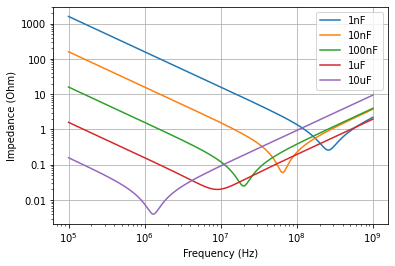

In [9]:
# code omitted from blog post
freq = np.logspace(5, 9, 1000)  # 100kHz to 1Ghz

z1n, _, _ = control.freqresp(cap1n, freq * math.tau)
z10n, _, _ = control.freqresp(cap10n, freq * math.tau)
z100n, _, _ = control.freqresp(cap100n, freq * math.tau)
z1u, _, _ = control.freqresp(cap1u, freq * math.tau)
z10u, _, _ = control.freqresp(cap10u, freq * math.tau)

plt.loglog(freq, z1n, label="1nF")
plt.loglog(freq, z10n, label="10nF")
plt.loglog(freq, z100n, label="100nF")
plt.loglog(freq, z1u, label="1uF")
plt.loglog(freq, z10u, label="10uF")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Impedance (Ohm)")
plt.grid()
plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%g"))

It is worth including some small capacitors with high-resonant frequencies in order to sink any high-frequency noise due to the switching frequency harmonics. It is hard to say how much to include without performing a high-fidelity power integrity analysis (using a tool such as [HyperLynx](https://eda.sw.siemens.com/en-US/pcb/hyperlynx/)).

In total we will select our final ceramic capacitance to be the parallel combination of 6x 10uF, 4x 1uF, 6x 47nF, and 8x 2.2nF. The resulting impedance from 100kHz to 1GHz is plotted below with the red dot signifying the impedance at the switching frequency (500kHz). The resulting steady-state voltage ripple is 4.4mV.

In [10]:
def parz(*args):
    # Return the parallel impedance of all arguments in the s-domain.
    if len(args) == 1:
        return args[0]
    else:
        z1 = args[0]
        z2 = parz(*args[1:])
        zpar = z1 * z2 / (z1 + z2)
        return control.minreal(zpar, verbose=False)

In [11]:
final_cercap = parz(cap10u / 8, cap1u / 4, cap47n / 6, cap2n2 / 8)
zfinal_cercap, _, _ = control.freqresp(final_cercap, freq * math.tau)
zripple = np.interp(fsw, freq, zfinal_cercap)
vripple = iripple * zripple
print("Voltage Ripple: {:0.1f} mV".format(vripple * 1e3))

Voltage Ripple: 4.4 mV


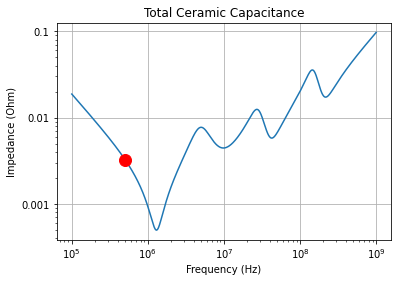

In [12]:
# code omitted from blog post
plt.loglog(freq, zfinal_cercap)
plt.plot(fsw, zripple, "ro", markersize=12)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Impedance (Ohm)")
plt.title("Total Ceramic Capacitance")
plt.grid()
plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%g"))

# Switch-Mode Regulator Transfer Function

 Resolving the transfer function from the feedback node to the control node to the output node will require parsing the datasheet and cross-referencing [Ridley Engineering's small-signal model for current-mode control](https://ridleyengineering.com/images/current_mode_book/CurrentModeControl.pdf).

In [13]:
# parameters from datasheet
vfb = 0.8  # 800 mV, feedback voltage
gm = 0.15e-3  # 15 mS, error amplifier transconductance
se = 1.87 * fsw  # 1.87 V/T, slope compensation (negative ramp)
rt = 0.089  # V/A, current sense gain

In [14]:
# formulas from Ridley Engineering
sf = iripple * rt * fsw / (1 - dutycycle)  # off-time slope
sn = iripple * rt * fsw / dutycycle  # on-time slope
alpha = (sf - se) / (sn + se)  # equation 3.3
ts = 1 / fsw
fmfi = (1 / rt) * control.tf(1 + alpha, [ts, 0])  # equation 3.13
qz = -2 / math.pi  # equation 4.4
wn = math.pi / ts  # equation 4.5
he = 1 + control.tf([1, 0], wn * qz) + control.tf([1, 0, 0], wn ** 2)  # equation 4.3
iLvC = fmfi / (1 + fmfi * rt * he)  # equation 3.14

NameError: name 'dutycycle' is not defined

In [ ]:
# control voltage to inductor current transfer function
mag, phase, omega = control.bode_plot(iLvC, omega_limits=(100, fsw / 2), Hz=True)

# Output Capacitance Impedance

Designing the output capacitance (and the error amplifier compensation network) of a switch-mode power converter is an iterative process focused on achieving two distinct performance goals:

2. Low voltage overshoot/undershoot in response to load step transients is achieved by increasing the amount of bulk capacitance. These are usually larger (low bandwidth) tantalum capacitors (high series resistance).

The response speed (rise time, settling time) is determined by the loop gain's crossover frequency. The loop gain's phase margin determines the amount of overshoot and ringing in the response. The designer will have to determine how to balance higher crossover frequency with larger phase margin; increasing one will often reduce the other.

## Bulk Capacitance

The amount of bulk capacitance required can be estimated by the load step current and the recovery time. Be mindful when selecting tantalum capacitors; manufacturers have a variety of series and case sizes that can result in series resistance ratings spanning an entire order of magnitude.

In [ ]:
crossover_freq = fsw / 6
recovery_time = 4 / crossover_freq
load_step = iout / 2
vout_transient = 100e-3
bulk_target = load_step * recovery_time / vout_transient
print("Target Bulk Capacitance: {:1.0f} uF".format(1e6 * bulk_target))

In [ ]:
def tantcap(c, esr):
    return control.tf(1, [c, 0]) + esr

In [ ]:
cap47u = tantcap(47e-6, 500e-3)  # AVX TAJC476K016RNJ
cap68u = tantcap(68e-6, 200e-3)  # AVX TPSC686K016R0200
cap100u = tantcap(100e-6, 125e-3)  # AVX TPSD107K016R0125
cap220u = tantcap(220e-6, 500e-3)  # KEMET T491X227K016AT

In [ ]:
freq = np.logspace(2, 5, 1000)  # 100Hz to 100kHz

z47u, _, _ = control.freqresp(cap47u, freq * math.tau)
z68u, _, _ = control.freqresp(cap68u, freq * math.tau)
z100u, _, _ = control.freqresp(cap100u, freq * math.tau)
z220u, _, _ = control.freqresp(cap220u, freq * math.tau)

plt.loglog(freq, z47u, label="47uF (AVX TAJ-C)")
plt.loglog(freq, z68u, label="68uF (AVX TPS-C)")
plt.loglog(freq, z100u, label="100uF (AVX TPS-D)")
plt.loglog(freq, z220u, label="220uF (KEMET T491-X)")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Impedance (Ohm)")
plt.grid()
plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%g"))

In [ ]:
final_tantcap = parz(cap220u / 4, cap100u / 4)

zfinal_tantcap, _, _ = control.freqresp(final_tantcap, freq * math.tau)

plt.loglog(freq, zfinal_tantcap)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Impedance (Ohm)")
plt.title("Total Tantalum Capacitance")
plt.grid()
plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%g"))

# Loop Gain Compensation

In [ ]:
rload = vout / iout
total_load = parz(final_cercap, final_tantcap, rload)

gdiv = vfb / vout
# chf = control.tf(1, [39e-12, 0])  # placeholder
ccomp = control.tf(1, [10e-12, 0])  # placeholder
rcomp = 200e3  # placeholder
compensation = gdiv * gm * (rcomp + ccomp)

loop = iLvC * total_load * compensation

_, _, _ = control.bode_plot(total_load, omega_limits=(100, fsw / 2), Hz=True)
_, _, _ = control.bode_plot(iLvC, omega_limits=(100, fsw / 2), Hz=True)
_, _, _ = control.bode_plot(compensation, omega_limits=(100, fsw / 2), Hz=True)
mag, phase, omega = control.bode_plot(loop, omega_limits=(100, fsw / 2), Hz=True)

wgc = interp1d(mag, omega)(1)
wgc / math.tau

In [ ]:
freq = math.tau * np.logspace(3, np.log10(fsw / 2), 1000)  # 100Hz to 100kHz
control.nichols_plot(loop, omega=freq)

# Signal Injection Transformer

A true signal injection transformer with flat amplitude over a wideband is expensive (more expensive than it should be; it's just a big ferrite core packaged in a nice box). There are a number of blogs which discuss repurposing transformers intended for other applications as a cheaper alternative ([Maxim Integrated](https://www.maximintegrated.com/en/design/technical-documents/app-notes/3/3245.html), [Electronic Projects for Fun](https://electronicprojectsforfun.wordpress.com/injection-transformers/)).

The following image is from [Mini-Circuits application note AN20-001](https://www.minicircuits.com/app/AN20-001.pdf). It shows the lumped parasitic model of a transformer. The following analysis only considers the magnetizing inductance (Lp) and primary winding resistance (R1), as these are the only parasitic values provided on the [PE-51687NL](https://www.digikey.com/en/products/detail/pulse-electronics-power/PE-51687NL/2266077?s=N4IgTCBcDaIAoFEC0BWAjANgBwHYByAMiALoC%2BQA) datasheet.

<img src="images/transformer_parasitic_model.png">

Note that for this signal injection application, the current sense transformer will be used in the reverse direction. The datasheet's "secondary" will be our "primary".

In [ ]:
Lp = 20e-3  # primary magnetizing inductance
R1 = 1.4  # primary winding resistance
n = 10 / 100  # 100-turn primary, 10-turn secondary
Rsrc = 25  #  primary drive, 50 Ohm series with 50 Ohm in shunt
Rload = 22  # secondary burden

In [ ]:
tf_Lp = control.tf([Lp, 0], 1)  # s-domain, s * Lp
Rload_xfmr = Rload / n ** 2  # primary reflected burden
tf_Lp_Rload_xfmr = tf_Lp * Rload_xfmr / (tf_Lp + Rload_xfmr)  # tf_Lp // Rload_xfmr
xfmr_vp = tf_Lp_Rload_xfmr / (Rsrc + R1 + tf_Lp_Rload_xfmr)  # primary winding voltage
xfmr_vs = xfmr_vp * n  # secondary winding voltage

In [ ]:
cutoff_frq = -control.pole(xfmr_vs)[1] / math.tau
dcgain = control.dcgain(xfmr_vs)
wbgain = np.abs(control.evalfr(xfmr_vs, 100 * cutoff_frq * math.tau))

print("DC Gain: {:0.2f} V/V".format(dcgain))
print("Wideband Gain: {:0.2f} V/V".format(wbgain))
print("Cutoff Frequency: {:0.0f} Hz".format(cutoff_frq))

In [ ]:
mag, phase, omega = control.bode_plot(xfmr_vs, omega_limits=(10, 1e6), Hz=True, dB=True)

In [ ]:
vt_limit = 100 * 600e-6 / n  # volt-time product, bipolar
frq_limit = cutoff_frq / 100  # arbitrary
vt_gain = control.evalfr(xfmr_vp, frq_limit * math.tau) / frq_limit
vsrc_limit = np.abs(vt_limit / vt_gain / 2)  # square half-wave

print("Vsrc Limit (Volt-Time Product): {:0.1f} V".format(vsrc_limit))
# conclusion: transformer would overheat long before core saturation